# A Gentle Introduction to HARK: Buffer Stock Saving 

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/gentle-intro-to-hark-buffer-stock-model#launch)

This notebook explores the behavior of a consumer identical to the perfect foresight consumer described in [Gentle-Intro-To-HARK-PerfForesightCRRA](https://econ-ark.org/materials/Gentle-Intro-To-HARK-PerfForesightCRRA) except that now the model incorporates income uncertainty.

In [1]:
# This cell has a bit of initial setup.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
import matplotlib.pyplot as plt

import numpy as np
import HARK 
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plot_funcs

## The Consumer's Problem with Transitory and Permanent Shocks
### Mathematical Description

Our new type of consumer receives two income shocks at the beginning of each period.  Permanent income would grow by a factor $\Gamma$ in the absence of any shock , but its growth is modified by a shock, $\psi_{t+1}$:
\begin{align}
 P_{t+1} & = \Gamma P_{t}\psi_{t+1}
\end{align}
whose expected (mean) value is $\mathbb{E}_{t}[\psi_{t+1}]=1$.  Actual income received $Y$ is equal to permanent income $P$ multiplied by a transitory shock $\theta$:
\begin{align}
 Y_{t+1} & = \Gamma P_{t+1}\theta_{t+1}
\end{align}
where again $\mathbb{E}_{t}[\theta_{t+1}] = 1$.

As with the perfect foresight problem, this model can be rewritten in terms of _normalized_ variables, e.g. the ratio of 'market resources' $M_{t}$ (wealth plus current income) to permanent income is $m_t \equiv M_t/P_t$.  (See [here](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/) for the theory).  In addition, lenders may set a limit on borrowing: The ratio $a_{t}$ of end-of-period assets to permanent income $A_t/P_t$ must be greater than $\underline{a} \leq 0$. (So, if $\underline{a}=-0.3$, the consumer cannot borrow more than 30 percent of their permanent income).  

The consumer's (normalized) problem turns out to be:
\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} ~~u(c_t) + \beta  \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ], \\
 & \text{s.t.} & \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& a_t  R/(\Gamma_{t+1} \psi_{t+1}) + \theta_{t+1}.
\end{eqnarray*}


For present purposes, we assume that the transitory and permanent shocks are independent.  The permanent shock is assumed to be (approximately) lognormal, while the transitory shock has two components: A probability $\wp$ that the consumer is unemployed, in which case $\theta^{u}=\underline{\theta}$, and a probability $(1-\wp)$ of a shock that is a lognormal with a mean chosen so that $\mathbb{E}_{t}[\theta_{t+n}]=1$.


### Representing the Income Shocks

Computers are discrete devices; even if somehow we knew with certainty that the transitory and permanent shocks were, say, continuously lognormally distributed, in order to be represented on a computer those distributions would need to be approximated by a finite set of points.  A large literature in numerical computation explores ways to construct such approximations; probably the easiest discretization to understand is the equiprobable approximation, in which the continuous distribution is represented by a set of $N$ outcomes that are equally likely to occur.  

In the case of a single variable (say, the permanent shock $\psi$), and when the number of equiprobable points is, say, 5, the procedure is to construct a list: $\psi^{0}$ is the mean value of the continuous $\psi$ given that the draw of $\psi$ is in the bottom 20 percent of the distribution of the continuous $\psi$.  $\psi^{1}$ is the mean value of $\psi$ given that the draw is between the 20th and 40th percentiles, and so on.  Having constructed these, the approximation to the expectation of some expression $g(\psi)$ can be very quickly calculated by:

$$ 
\mathbb{E}_{t}[g(\psi)] \equiv \int_{0}^{\infty} g(\psi) dF_{\psi} \approx (1/N) \sum_{i=0}^{N-1} g(\psi^{i}).
$$

(For a graphical depiction of a particular instance of this, see [SolvingMicroDSOPs/#discreteApprox](http://www.econ2.jhu.edu/people/ccarroll/SolvingMicroDSOPs/#discreteApprox).)

## The New Parameters

In addition to the parameters required for the perfect foresight model (like the time preference factor $\beta$), under the assumptions above, we need to choose values for the following extra parameters that describe the income shock distribution and the artificial borrowing constraint.

| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\underline{a}$ | Artificial borrowing constraint | $\texttt{BoroCnstArt}$ | 0.0 |
| $\sigma_\psi$ | Underlying stdev of permanent income shocks | $\texttt{PermShkStd}$ | 0.1 |
| $\sigma_\theta^{e}$ | Underlying stdev of transitory income shocks | $\texttt{TranShkStd}$ | 0.1 |
| $N_\psi$ | Number of discrete permanent income shocks | $\texttt{PermShkCount}$ | 7 |
| $N_\theta$ | Number of discrete transitory income shocks | $\texttt{TranShkCount}$ | 7 |
| $\wp$ | Unemployment probability | $\texttt{UnempPrb}$ | 0.05 |
| $\underline{\theta}$ | Transitory shock when unemployed | $\texttt{IncUnemp}$ | 0.3 |

## Representation in HARK

HARK agents with this kind of problem are instances of the class $\texttt{IndShockConsumerType}$, which is constructed by "inheriting" the properties of the $\texttt{PerfForesightConsumerType}$ and then adding only the _new_ information required:

In [2]:
# This cell defines a parameter dictionary for making an instance of IndShockConsumerType.

IndShockDictionary = {
    'PermShkStd': [0.1],  # ... by specifying the new parameters for constructing the income process.    
    'PermShkCount': 7,
    'TranShkStd': [0.1],
    'TranShkCount': 7,
    'UnempPrb': 0.05,
    'IncUnemp': 0.3, # ... and income for unemployed people (30 percent of "permanent" income)
    'BoroCnstArt': 0.0, # ... and specifying the location of the borrowing constraint (0 means no borrowing is allowed)
    'cycles': 0         # signifies an infinite horizon solution (see below)
}

## Other Attributes are Inherited from PerfForesightConsumerType

You can see all the **attributes** of an object in Python by using the `dir()` command. From the output of that command below, you can see that many of the model variables are now attributes of this object, along with many other attributes that are outside the scope of this tutorial.

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType

pfc = PerfForesightConsumerType()
dir(pfc)

['AgentCount',
 'BoroCnstArt',
 'CRRA',
 'DiscFac',
 'LivPrb',
 'MaxKinks',
 'PermGroFac',
 'PermGroFacAgg',
 'RNG',
 'Rfree',
 'T_age',
 'T_cycle',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aNrmInitMean',
 'aNrmInitStd',
 'add_to_time_inv',
 'add_to_time_vary',
 'assign_parameters',
 'cFunc_terminal_',
 'checkAIC',
 'checkCondition',
 'checkConditions',
 'checkFHWC',
 'checkGICPF',
 'checkRIC',
 'check_elements_of_time_vary_are_lists',
 'check_restrictions',
 'clear_history',
 'controls',
 'cycles',
 'del_from_time_inv',
 'del_from_time_vary',
 'getRfree',
 'get_controls',
 'get_mortality',
 'get_parameter',
 'get_poststates',
 'get_shocks',
 'get_states',
 'hi

In python terminology, `IndShockConsumerType` is a **superclass** of `PerfForesightConsumerType`. This means that it builds on the functionality of its parent type (including, for example, the definition of the utility function). You can find the superclasses of a type in Python using the `__bases__` attribute:

In [4]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

IndShockConsumerType.__bases__

(HARK.ConsumptionSaving.ConsIndShockModel.PerfForesightConsumerType,)

In [5]:
# So, let's create an instance of the IndShockConsumerType
IndShockExample = IndShockConsumerType(**IndShockDictionary)

As before, we need to import the relevant subclass of $\texttt{AgentType}$ into our workspace, then create an instance by passing the dictionary to the class as if the class were a function.

## The Discretized Probability Distribution

The scatterplot below shows how the discretized probability distribution is represented in HARK: The lognormal distribution is represented by a set of equiprobable point masses.

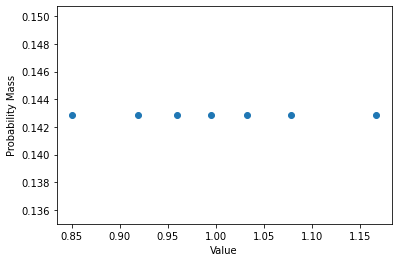

In [6]:
# Plot values for equiprobable distribution of permanent shocks

plt.scatter(IndShockExample.PermShkDstn[0].X,
            IndShockExample.PermShkDstn[0].pmf)
plt.xlabel("Value")
plt.ylabel("Probability Mass")
plt.show()

This distribution was created, using the parameters in the dictionary above, when the `IndShockConsumerType` object was initialized.

## Solution by Backwards Induction

HARK solves this problem using _backwards induction_: It will derive a solution for each period ($t$) by finding a mapping between specific values of market resources $\{m[0],m[1],...\}$ and the corresponding optimal consumption $\{c[0],c[1],...\}$. The function that "connects the dots" will be stored in a variable named `cFunc`.

Backwards induction requires a "terminal" (last; final) period to work backwards from.  `IndShockExample` constructed above did not specify a terminal consumption function, and consequently it uses the default terminal function in which all resources are consumed: $c_{T} = m_{t}$. 

In [7]:
IndShockExample.solution_terminal

The consumption function `cFunc` is defined by _piecewise linear interpolation_.

It is defined by a series of $(m,c)$ points on a grid; the value of the function for any $m$ is the $c$ determined by the line connecting the nearest defined gridpoints.

You can see below that in the terminal period, $c = m$; the agent consumes all available resources.

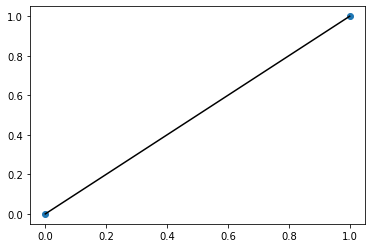

In [8]:
# Plot terminal consumption function
plt.plot(IndShockExample.solution_terminal.cFunc.x_list,
         IndShockExample.solution_terminal.cFunc.y_list,
         color='k')
plt.scatter(IndShockExample.solution_terminal.cFunc.x_list,
            IndShockExample.solution_terminal.cFunc.y_list)

The solution also has a representation of a `value function`, the value `v(m)` as a function of available market resources. Because the agent consumes all their resources in the last period, the value function for the terminal solution looks just like the CRRA utility function: $v_{T}(m) = u(m)$.

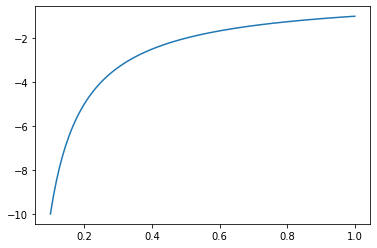

In [9]:
# Final consumption function c=m
m = np.linspace(0.1,1,100)
plt.plot(m,IndShockExample.solution_terminal.vFunc(m))

## Solving the problem

This solution is generated by invoking `solve()` which is a **method** that is an **attribute** of the `IndShockExample` object. **Methods** in Python are supposed to have **documentation** that tell you what they do. You can read the documentation for methods and other attributes in HARK with the built-in Python `help()` function:

In [10]:
help(IndShockExample.solve)

Help on method solve in module HARK.core:

solve(verbose=False) method of HARK.ConsumptionSaving.ConsIndShockModel.IndShockConsumerType instance
    Solve the model for this instance of an agent type by backward induction.
    Loops through the sequence of one period problems, passing the solution
    from period t+1 to the problem for period t.
    
    Parameters
    ----------
    verbose : boolean
        If True, solution progress is printed to screen.
    
    Returns
    -------
    none



### Finite or Infinite Horizon?

$\texttt{ConsIndShockType}$ can solve either finite-horizon (e.g., life-cycle) problems, or infinite-horizon problems (where the problem is the same in every period).  Elsewhere you can find documentation about the finite horizon solution; here we are interested in the infinite-horizon solution which is obtained (by definition) when iterating one more period yields a solution that is essentially the same.  In the dictionary above we signaled to HARK that we want the infinite horizon solution by setting the "cycles" paramter to zero:

In [11]:
IndShockExample.cycles # Infinite horizon solution is computed when cycles = 0

0

In [12]:
# Solve It
IndShockExample.solve(verbose=True) # Verbose prints progress as solution proceeds

GPFPF            = 0.984539 
GPFInd           = 0.993777 
GPFAgg           = 0.964848 
Thorn = APF      = 0.994384 
PermGroFacAdj    = 1.000611 
uInvEpShkuInv    = 0.990704 
FVAF             = 0.932054 
WRPF             = 0.213705 
DiscFacGPFIndMax = 0.972061 
DiscFacGPFAggMax = 1.010600 


Finished cycle #1 in 0.00638890266418457 seconds, solution distance = 100.0
Finished cycle #2 in 0.01588129997253418 seconds, solution distance = 10.088015890333434
Finished cycle #3 in 0.0295257568359375 seconds, solution distance = 3.3534114736589693
Finished cycle #4 in 0.014039993286132812 seconds, solution distance = 1.6699529613894288
Finished cycle #5 in 0.013993978500366211 seconds, solution distance = 0.9967360674688521
Finished cycle #6 in 0.011996984481811523 seconds, solution distance = 0.6602619046109499
Finished cycle #7 in 0.012526750564575195 seconds, solution distance = 0.46809484231437537
Finished cycle #8 in 0.01412200927734375 seconds, solution distance = 0.34807706501006663
Finished cycle #9 in 0.011273384094238281 seconds, solution distance = 0.2681341538834978
Finished cycle #10 in 0.013538599014282227 seconds, solution distance = 0.21223248168627507
Finished cycle #11 in 0.01338648796081543 seconds, solution distance = 0.17162798586899441
Finished cycle #12 in 0

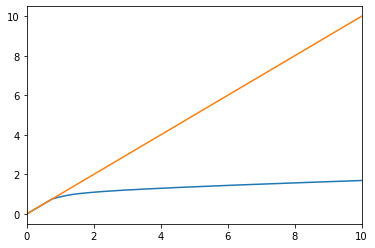

In [13]:
# plot_funcs([list],min,max) takes a [list] of functions and plots their values over a range from min to max
plot_funcs([IndShockExample.solution[0].cFunc,IndShockExample.solution_terminal.cFunc],0.,10.)

## Changing Constructed Attributes

In the parameter dictionary above, we chose values for HARK to use when constructing its numerical representation of $F_t$, the joint distribution of permanent and transitory income shocks. When $\texttt{IndShockExample}$ was created, those parameters ($\texttt{TranShkStd}$, etc) were used by the **constructor** or **initialization** method of $\texttt{IndShockConsumerType}$ to construct an attribute called $\texttt{IncomeDstn}$.

Suppose you were interested in changing (say) the amount of permanent income risk.  From the section above, you might think that you could simply change the attribute $\texttt{TranShkStd}$, solve the model again, and it would work.

That's _almost_ true-- there's one extra step. $\texttt{TranShkStd}$ is a primitive input, but it's not the thing you _actually_ want to change. Changing $\texttt{TranShkStd}$ doesn't actually update the income distribution... unless you tell it to (just like changing an agent's preferences does not change the consumption function that was stored for the old set of parameters -- until you invoke the $\texttt{solve}$ method again).  In the cell below, we invoke the method $\texttt{updateIncomeProcess}$ so HARK knows to reconstruct the attribute $\texttt{IncomeDstn}$.

In [14]:
OtherExample = deepcopy(IndShockExample)  # Make a copy so we can compare consumption functions
OtherExample.PermShkStd = [0.2]           # Double permanent income risk (note that it's a one element list)
OtherExample.updateIncomeProcess()        # Call the method to reconstruct the representation of F_t
OtherExample.solve()

GPFPF            = 0.984539 
GPFInd           = 1.021965 
GPFAgg           = 0.964848 
Thorn = APF      = 0.994384 
PermGroFacAdj    = 0.973012 
uInvEpShkuInv    = 0.963379 
FVAF             = 0.906347 
WRPF             = 0.213705 
DiscFacGPFIndMax = 0.919178 
DiscFacGPFAggMax = 1.010600 


In the cell below, use your blossoming HARK skills to plot the consumption function for $\texttt{IndShockExample}$ and $\texttt{OtherExample}$ on the same figure.

In [15]:
# Use the remainder of this cell to plot the IndShockExample and OtherExample consumption functions against each other

## Buffer Stock Saving?

There are some combinations of parameter values under which problems of the kind specified above have "degenerate" solutions; for example, if consumers are so patient that they always prefer deferring consumption to the future, the limiting consumption rule can be $c(m)=0$.  

The toolkit has built-in tests for a number of parametric conditions that can be shown to result in various characteristics in the optimal solution.

Perhaps the most interesting such condition is the ["Growth Impatience Condition"](http://econ.jhu.edu/people/ccarroll/Papers/BufferStockTheory/#GIC): If this condition is satisfied, the consumer's optimal behavior is to aim to achieve a "target" value of $m$, to serve as a precautionary buffer against income shocks.

The tests can be invoked using the `checkConditions()` method:

In [16]:
IndShockExample.checkConditions(verbose=True)

GPFPF            = 0.984539 
GPFInd           = 0.993777 
GPFAgg           = 0.964848 
Thorn = APF      = 0.994384 
PermGroFacAdj    = 1.000611 
uInvEpShkuInv    = 0.990704 
FVAF             = 0.932054 
WRPF             = 0.213705 
DiscFacGPFIndMax = 0.972061 
DiscFacGPFAggMax = 1.010600 
